In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from tqdm import tqdm

# Problem 1.3.3 Computational Verification 

In [2]:
graph_a = np.array([[0,1,0,0,0,1],[1,0,1,0,0,1],[0,1,0,1,0,1],[0,0,1,0,0,0],[0,0,0,0,0,1],[1,1,1,0,1,0]])
graph_b = np.array([[0,1,1,0,0,1],[1,0,1,0,0,0],[1,1,0,0,0,1],[0,0,0,0,0,1],[0,0,0,0,0,1],[1,0,1,1,1,0]])

In [3]:
b_G = nx.from_numpy_array(graph_a)
a_G = nx.from_numpy_array(graph_b)

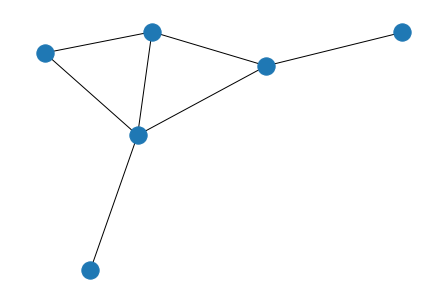

In [4]:
nx.draw(b_G)
plt.show()

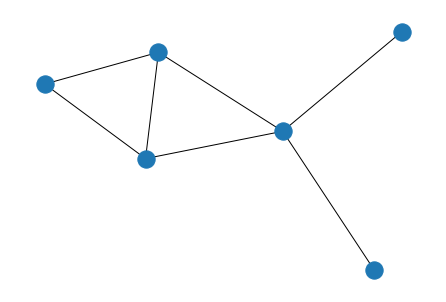

In [5]:
nx.draw(a_G)

## Initialize Graph Layers

In [6]:
class GNNLayer(torch.nn.Module):
    def __init__(self):
        super(GNNLayer, self).__init__()
        self.alpha = torch.nn.Parameter(torch.randn(1))
        self.alpha.requires_grad = True
        self.beta = torch.nn.Parameter(torch.randn(1))
        self.beta.requires_grad = True



    def forward(self, x, edges):
        feats = x.reshape(-1, 1)
        out2 = edges @ feats
        lin_out = self.alpha * feats + self.beta*out2 
        out = F.leaky_relu(lin_out)
        return out



        


In [7]:
layer1 = GNNLayer()
layer2 = GNNLayer()

#### Result of first graph layer is the same therefore the NN will not be able to learn. 

In [8]:
grapha_sum = graph_a.sum(axis = 0)
graphb_sum =  graph_b.sum(axis = 0)
with torch.no_grad():
    graph_a_out, graph_b_out  = layer1(grapha_sum, graph_a), layer1(graphb_sum, graph_b)

torch.sum(graph_a_out)/6, torch.sum(graph_b_out)/6

(tensor(-0.0716, dtype=torch.float64), tensor(-0.0716, dtype=torch.float64))

### Second layer gives different representations meaning that with two layers we can learn a fucntion on this domain. 

In [9]:
with torch.no_grad():
    grapha2_out, graphb2_out = layer2(graph_a_out.float(), torch.Tensor(graph_a)), layer2(graph_b_out.float(), torch.Tensor(graph_b))


torch.sum(grapha2_out)/6, torch.sum(graphb2_out)/6

(tensor(-0.0005), tensor(-0.0005))

# Problem 2 

## (2.4) Data Generator Class for Generating Graphs

In [10]:
class DataGenerator:
    def __init__(self, n: int, K:int):
        self.n = n
        self.K = K

    def SBM(self, s:int):
        p = (12 + s)/self.n
        q = (8 -s)/self.n
        ind = torch.arange(0, self.n)
        partition = torch.randint(0, self.n, (self.n//2,))
        mask = torch.ones(ind.numel(), dtype=torch.bool)
        mask[partition] = False
        c1, c2 = ind[partition], ind[mask]
        labels = torch.zeros(self.n)
        labels[partition] = 1
        labels[mask] = -1
        E = torch.stack([torch.where(x == labels, p, q) for x in labels])
        E = torch.bernoulli(E)
        return labels, E

    def create_data(self, S:int, singular = True):
        if singular:
            data = [self.SBM(S) for k in range(self.K)]
        else:
            data = [[self.SBM(s) for k in range(self.K)] for s in range(1, S+1)]
        return data





## Helper functions for creating and drawing graphs in the NX format


In [11]:
def create_graph(Graph):
    node_label, edges = Graph[0][0], Graph[0][1]
    node_label, edges = node_label.numpy(), edges.numpy()
    nodes = np.arange(0, 1000)
    G = nx.from_numpy_array(edges)
    node_attr = {n: y for n, y in zip(nodes, node_label)}
    nx.set_node_attributes(G, node_attr, "Class")
    color_map = ['red' if val == 1 else 'green' for val in node_attr.values()]
    return G, color_map

In [12]:
def draw_graph(G, cm):
    nx.draw(G, node_color=cm, node_size=8, width=.1, pos = nx.spring_layout(G))

## Plot example for each setting of s

In [13]:
TrainData = DataGenerator(1000, 100).create_data(5, singular=False)

In [14]:

ValidData = DataGenerator(1000, 20).create_data(5, singular = False)

In [15]:

TestData = DataGenerator(1000, 100).create_data(5, singular = False)

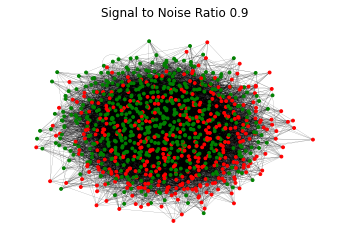

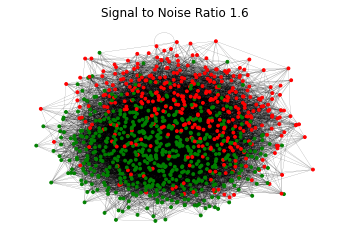

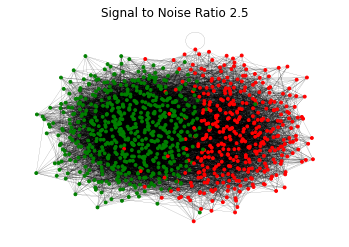

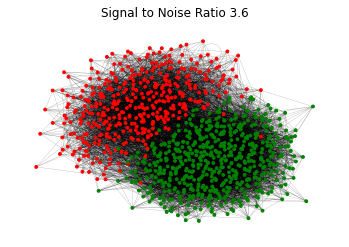

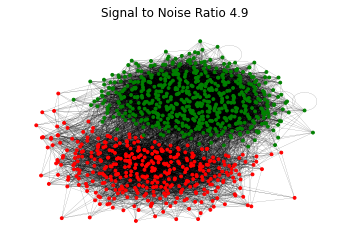

In [16]:
for i,g in enumerate(TrainData):
    s = i + 1
    a = 12 + i + 1
    b = 8 - (i + 1)
    snr = (a-b)**2/(2*(a + b))
    plt.title(f"Signal to Noise Ratio {snr}")
    G, color_map = create_graph(g)
    draw_graph(G, color_map)
    plt.show()

## (2.5) Overlap Bounds

In [17]:
def get_overlap(pred, target1, target2):
    n = len(pred)
    s1 = torch.sum((pred == target1)) 
    s2 = torch.sum((pred == target2))
    overlap = 2*((1/n)*torch.max(s1, s2)-.5)
    return overlap

In [18]:
#Settings for best and worst case scenarios in prediction 
toy_target = torch.tensor([1,1,1,-1,-1,-1])
toy_prediction = torch.tensor([1,1,1,-1,-1,-1])
toy_pred2 = torch.ones(6)

In [19]:
get_overlap(toy_target, toy_pred2, -toy_pred2) #Lower Bound on the Overlap 

tensor(0.)

In [20]:
get_overlap(toy_target, toy_prediction, -toy_prediction) #Upper bound on the overlap 

tensor(1.)

## (2.6) GCN Model 

In [21]:
class GNN(torch.nn.Module):
    def __init__(self, BS, n_features):
        super(GNN, self).__init__()
        self.g1 = GNNLayer()
        self.g2 = GNNLayer()
        self.g3 = GNNLayer()
        self.bn = torch.nn.BatchNorm1d(n_features)
        self.fc = torch.nn.Sequential(nn.Linear(1, 50), 
        nn.LeakyReLU(), 
        nn.Linear(50, 25), 
        nn.LeakyReLU(),
        nn.Linear(25, 2))
        
    def forward(self, x, edges):
        out = self.g1(x, edges)
        out = self.bn(out)
        out =self.g2(out, edges)
        out = self.bn(out)
        out = self.g3(out, edges) 
        out = self.bn(out)
        out = self.fc(out)
        return out 

    


### Loss and Step Functions

In [22]:
def get_loss_and_correct(m, batch, criterion, device):
    target, data = batch
    feats = torch.sum(data, dim=1)
    target = target.long()
    feats, target, edges = feats.to(device), target.to(device), data.to(device)
    pred = m(feats, edges)
    target1 = torch.where(target == -1, 0, 1)
    target2 = -target
    target2 =  torch.where(target2 == -1, 0, 1)
    # print(target1)
    l1 = criterion(pred, target1)
    l2 = criterion(pred, target2)
    loss_tensor = torch.Tensor([l1, l2])
    loss_ind = torch.argmin(loss_tensor)
    if loss_ind == 0:
        loss = l1
    else:
        loss = l2
    classes = pred.max(dim=1)[1]
    overlap = get_overlap(classes, target1, target2)

    return loss, overlap

def step(l, opt):
    opt.zero_grad()
    l.backward()
    opt.step()

### Train Validation and Test Loop

In [23]:
def train_validation_test(train_data, valid_data, test_data, device, s):
    EPOCHS = 25
    BATCH_SIZE = 1
    model = GNN(BATCH_SIZE, 1)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()

    model.to(device)
    criterion.to(device)

    train_losses = []
    train_overlap = []
    valid_losses = []
    valid_overlap = []




    pbar = tqdm(range(EPOCHS))

    for i in pbar:
        total_train_overlap = 0.
        total_train_loss = 0. 
        total_valid_overlap = 0. 
        total_valid_loss = 0. 

        for batch in train_data:
            loss, overlap = get_loss_and_correct(model, batch, criterion, device)
            step(loss, optimizer)
            # plot_grad_flow(model.named_parameters())
            total_train_loss += loss.item()
            total_train_overlap += overlap.item()
        
        with torch.no_grad():
            for batch in valid_data:
                loss, overlap = get_loss_and_correct(model, batch, criterion, device)
                total_valid_loss += loss.item()
                total_valid_overlap += overlap.item()


        mean_train_loss = total_train_loss/ len(train_data)
        mean_train_overlap = total_train_overlap / len(train_data)


        mean_validation_loss = total_valid_loss/len(valid_data)
        mean_validation_overlap = total_valid_overlap/len(valid_data)

        train_losses.append(mean_train_loss)
        train_overlap.append(mean_train_overlap)

        valid_losses.append(mean_validation_loss)
        valid_overlap.append(mean_validation_overlap)

        pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_overlap': mean_train_overlap, 'validation_overlap': mean_validation_overlap})

    total_test_overlap = 0. 
    total_test_loss = 0.  
    with torch.no_grad():
        for batch in test_data:
            loss, overlap = get_loss_and_correct(model, batch, criterion, device)
            total_test_loss += loss.item()
            total_test_overlap += overlap.item()

    avg_test_overlap = total_test_overlap/len(test_data)            

    return avg_test_overlap

### Function to train model and get test overlap and signal to noise ratio

In [24]:
def overlap_snr(train_datasets, valid_datasets, test_datasets):
    snrs = []
    overlaps = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for i, data in tqdm(enumerate(zip(train_datasets, valid_datasets, test_datasets))):
        overlap = train_validation_test(data[0], data[1], data[2], device, i+1)
        print(overlap)
        print(i+1)
        a = 12 + i + 1
        b = 8 - (i + 1)
        snr = (a-b)**2/(2*(a + b))
        snrs.append(snr)
        overlaps.append(overlap)
    
    return  overlaps, snrs


         
    

In [25]:
overlaps, snrs = overlap_snr(TrainData, ValidData, TestData)

0it [00:00, ?it/s]
100%|██████████| 25/25 [00:19<00:00,  1.31it/s, train_loss=0.642, validation_loss=0.641, train_overlap=0.28, validation_overlap=0.289]
1it [00:21, 21.81s/it]

0.2857200646400452
1



100%|██████████| 25/25 [00:19<00:00,  1.30it/s, train_loss=0.538, validation_loss=0.531, train_overlap=0.452, validation_overlap=0.468]
2it [00:41, 20.50s/it]

0.46088007688522337
2



100%|██████████| 25/25 [00:19<00:00,  1.30it/s, train_loss=0.394, validation_loss=0.385, train_overlap=0.646, validation_overlap=0.651]
3it [01:01, 20.10s/it]

0.6419200778007508
3



100%|██████████| 25/25 [00:19<00:00,  1.30it/s, train_loss=0.215, validation_loss=0.216, train_overlap=0.837, validation_overlap=0.838]
4it [01:20, 19.88s/it]

0.83468008518219
4



100%|██████████| 25/25 [00:19<00:00,  1.29it/s, train_loss=0.104, validation_loss=0.106, train_overlap=0.923, validation_overlap=0.924]
5it [01:40, 20.04s/it]

0.9203400897979737
5


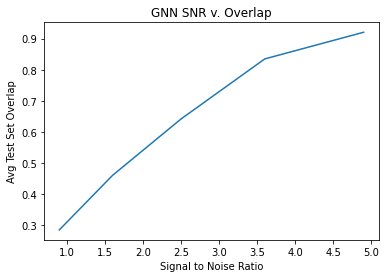

In [26]:
plt.title("GNN SNR v. Overlap")
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Avg Test Set Overlap")
plt.plot(snrs, overlaps)
plt.show()

## (2.7) Baseline comparison with spectral method

In [27]:
def overlap2(estimator, y):
    y = y.numpy()
    target1 = y
    target2 = -y
    n = len(estimator)
    s1 = np.sum((estimator == target1)) 
    s2 = np.sum((estimator == target2))
    overlap = 2*((1/n)*max(s1, s2)-.5)

    return overlap

### Baseline Community Estimator 

In [28]:
def community_estimator(edges):
    _, evecs = np.linalg.eigh(edges)
    fiedler_vec = evecs[:,-2]
    estimator = np.sign(fiedler_vec)
    return estimator 

In [29]:
def baseline(datasets):
    snrs = []
    overlaps = []
    for i, data in enumerate(tqdm(datasets)):
        results = [overlap2(community_estimator(batch[1]), batch[0]) for batch in data]
        overlap = sum(results)/len(results)
        print(overlap)
        print(i+1)
        a = 12 + i + 1
        b = 8 - (i + 1)
        snr = (a-b)**2/(2*(a + b))
        snrs.append(snr)
        overlaps.append(overlap)
    
    return  overlaps, snrs


         

In [30]:
base_overlap, base_snr = baseline(TrainData) 

 20%|██        | 1/5 [00:36<02:26, 36.66s/it]

0.09126000000000005
1


 40%|████      | 2/5 [01:13<01:49, 36.60s/it]

0.22934
2


 60%|██████    | 3/5 [01:49<01:13, 36.58s/it]

0.54932
3


 80%|████████  | 4/5 [02:26<00:36, 36.55s/it]

0.6739599999999997
4


100%|██████████| 5/5 [03:02<00:00, 36.58s/it]

0.74646
5


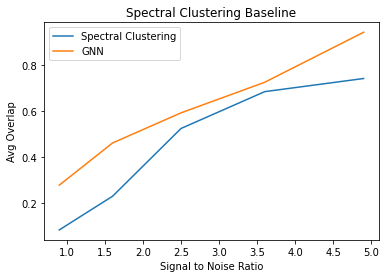

In [72]:
plt.title("Spectral Clustering Baseline")
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Avg Overlap")
plt.plot(base_snr, base_overlap, label = "Spectral Clustering")
plt.plot(snrs, overlaps, label = "GNN")
plt.legend()
plt.show()